In [45]:
# xai_roberta_explainer.ipynb
# Пояснения (по-русски):
# -------------------------------------------------------------
# В этом коде:
# 1) Загружаем модель RobertaForSequenceClassification (DistilRoberta или Roberta),
#    которую вы уже обучили.
# 2) Реализуем Gradient × Input, адаптируя к roberta-архитектуре.
# 3) Показываем упрощённый пример LRP (mock), так как настоящее Conservative LRP
#    требует патчей внутр. слоёв.
# 4) Визуализируем релевантность в виде bar chart.
# 5) Выполняем perturbation эксперименты.

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import RobertaForSequenceClassification, RobertaTokenizer

In [46]:
# 1) Choose your checkpoint (path or HF hub)
checkpoint_path = "distilroberta_finetuned_v2"  # Adjust to your actual path
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")

print("Using device:", device)

# Load model and tokenizer
model = RobertaForSequenceClassification.from_pretrained(checkpoint_path)
tokenizer = RobertaTokenizer.from_pretrained(checkpoint_path)
model.to(device)
model.eval()

Using device: mps


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [47]:
# ======= STEP 2: Gradient × Input for RoBERTa =======
# Пояснения (по-русски):
# Для корректного Grad×Input мы хотим получить:
#  - input_embeddings (word embeddings) с requires_grad_(True)
#  - forward pass -> logit[target_label].backward()
#  - relevance = grad * emb
#
# Но RobertaForSequenceClassification не предоставляет прямого input_embeds=...,
# поэтому делаем "hook" или вручную получаем embeddings, тогда backward.

def grad_x_input_roberta(model, tokenizer, text, device, target_label=None):
    """
    Compute Gradient × Input for a single text (batch_size=1).
    1) Tokenize
    2) Convert input_ids -> embeddings with requires_grad
    3) Forward pass (manually setting inputs_embeds=...) while passing
       attention_mask, token_type_ids if needed.
    4) backward() on the chosen logit
    5) relevance = grad * embeddings
    6) return (tokens, relevance_scores)
    """
    model.zero_grad()
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt")
    for k, v in inputs.items():
        inputs[k] = v.to(device)

    # We get word embeddings from model.roberta.embeddings.word_embeddings
    with torch.no_grad():
        base_emb = model.roberta.embeddings.word_embeddings(inputs["input_ids"])
    base_emb = base_emb.clone().detach().requires_grad_(True)

    # Forward pass using inputs_embeds instead of input_ids
    attention_mask = inputs.get("attention_mask", None)
    # DistilRoBERTa doesn't have token_type_ids, typically

    outputs = model(
        inputs_embeds=base_emb,
        attention_mask=attention_mask
    )
    logits = outputs.logits
    if target_label is None:
        target_label = torch.argmax(logits, dim=1)
    chosen_logit = logits[0, target_label]

    # Backward
    chosen_logit.backward(retain_graph=True)

    # Now base_emb.grad holds gradients wrt embeddings
    if base_emb.grad is None:
        raise RuntimeError("Grad is None, ensure everything is on same device and you used inputs_embeds=...")

    grad = base_emb.grad.detach()  # shape [1, seq_len, hidden_dim]
    relevance = grad * base_emb.detach()  # elementwise

    input_ids = inputs["input_ids"][0].detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)

    # sum across hidden_dim
    relevance_scores = relevance.sum(dim=-1).squeeze(0).cpu().numpy()  # shape [seq_len]
    return tokens, relevance_scores, logits

def clean_token(token: str):
    # Remove leading "Ġ" or "g" if that's how it appears
    if token.startswith("Ġ"):
        return token[1:]
    if token.startswith("g") and token != "g":
        return token[1:]
    return token

def visualize_relevance(tokens, relevance_scores, title="Grad × Input Relevance"):
    """
    Simple bar chart for token-level relevance (Gradient × Input).
    """
    cleaned_tokens = []
    cleaned_scores = []
    for t, s in zip(tokens, relevance_scores):
        if t not in ["<s>", "</s>", "<pad>"]:
            # чистим сам токен
            ct = clean_token(t)
            cleaned_tokens.append(ct)
            cleaned_scores.append(s)

    x = np.arange(len(cleaned_tokens))
    plt.figure(figsize=(12, 4))
    colors = ["red" if sc < 0 else "green" for sc in cleaned_scores]
    plt.bar(x, cleaned_scores, color=colors)
    plt.xticks(x, cleaned_tokens, rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [48]:
# ====== List of 18 sentences (English) with their RU text or context ======
sample_sentences = [
    # happiness (3)
    {"ru_text":"Всё было шикарно.","text":"everything was gorgeous","general_emotion":"happiness"},
    {"ru_text":"В целом, вечер у Лидии мне понравился.","text":"in general i liked lydia evening","general_emotion":"happiness"},
    {"ru_text":"И я искренне её полюбила.","text":"and i sincerely fell in love with her","general_emotion":"happiness"},

    # sadness (3)
    {"ru_text":"Боль, тоска в душе","text":"pain longing in the soul","general_emotion":"sadness"},
    {"ru_text":"Без общения больше месяца","text":"without communication for more than a month","general_emotion":"sadness"},
    {"ru_text":"Мазурка сербского оказалась плоским пирогом, весьма сухим.","text":"serbian mazurka turned out to be a flat pie very dry","general_emotion":"sadness"},

    # anger (3)
    {"ru_text":"У меня большие претензии к блюдам.","text":"i have big complaints about dishes","general_emotion":"anger"},
    {"ru_text":"И я думаю, он подверг критике то, что было блюдо со свининой.","text":"and i think he criticized what was a dish with pork","general_emotion":"anger"},
    {"ru_text":"Но я, если честно, руками есть не люблю.","text":"but to be honest i don t like my hands","general_emotion":"anger"},

    # surprise (3)
    {"ru_text":"Я его половую принадлежность даже не могу понять.","text":"i can not even understand his gender","general_emotion":"surprise"},
    {"ru_text":"что между ними возникла взаимная симпатия.","text":"that mutual sympathy arose between them","general_emotion":"surprise"},
    {"ru_text":"Вы знаете, я немножечко о каждом уже кое-что знаю.","text":"you know i already know something a little about everyone","general_emotion":"surprise"},

    # fear (3)
    {"ru_text":"Скажу откровенно, я не знала ведь, кто ко мне придет,","text":"frankly i did not know who would come to me","general_emotion":"fear"},
    {"ru_text":"Я боюсь к нему идти.","text":"i m afraid to go to him","general_emotion":"fear"},
    {"ru_text":"Очень вкусно, но я боюсь, что там","text":"very tasty but i m afraid that there","general_emotion":"fear"},

    # disgust (3)
    {"ru_text":"Желудок-то забитый у вас у всех.","text":"the stomach is clogged with you all","general_emotion":"disgust"},
    {"ru_text":"острое неприятие","text":"acute rejection","general_emotion":"disgust"},
    {"ru_text":"того блюда, которое тебе подали.","text":"the dishes that you were served","general_emotion":"disgust"}
]


=== Example 1 ===
Emotion: happiness
RU text: Всё было шикарно.
EN text: everything was gorgeous
Predicted emotion: LABEL_3


/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()


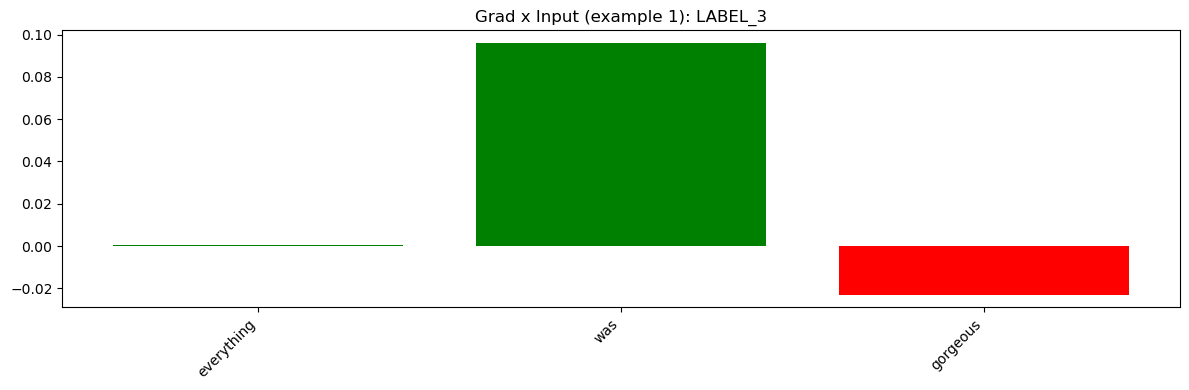


=== Example 2 ===
Emotion: happiness
RU text: В целом, вечер у Лидии мне понравился.
EN text: in general i liked lydia evening
Predicted emotion: LABEL_3


/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()


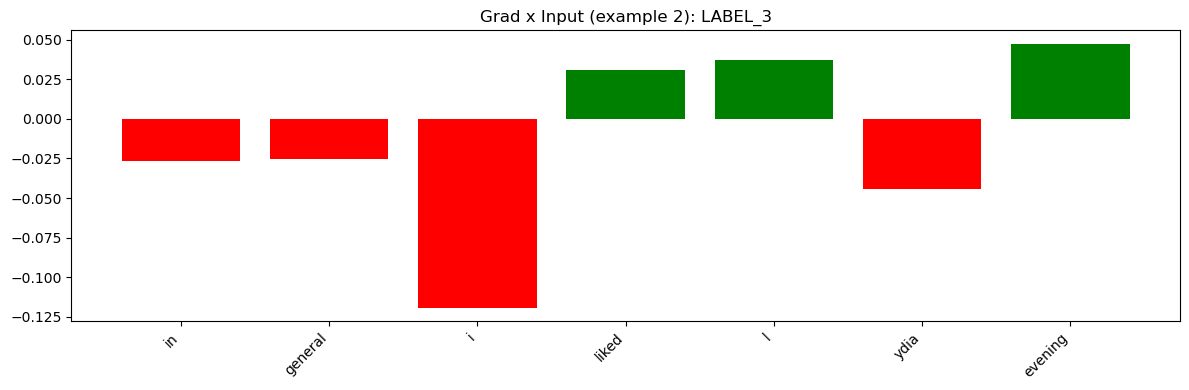


=== Example 3 ===
Emotion: happiness
RU text: И я искренне её полюбила.
EN text: and i sincerely fell in love with her
Predicted emotion: LABEL_3


/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()


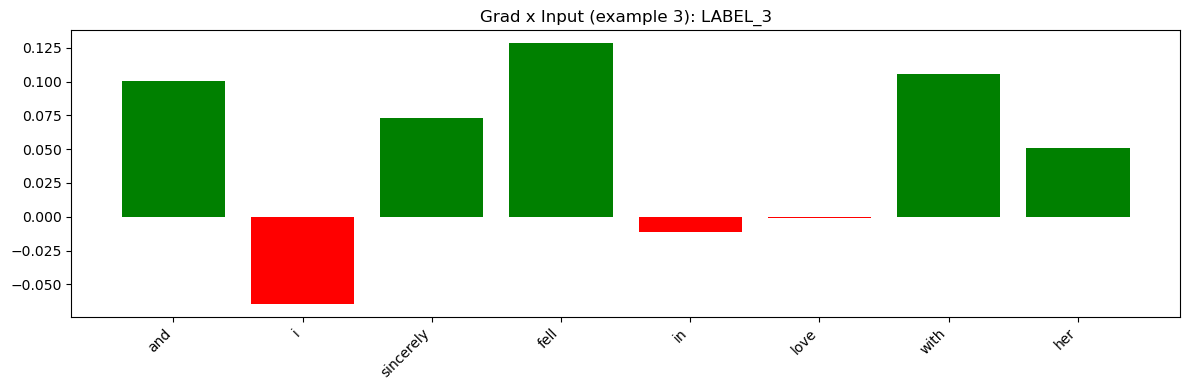


=== Example 4 ===
Emotion: sadness
RU text: Боль, тоска в душе
EN text: pain longing in the soul
Predicted emotion: LABEL_5


/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()


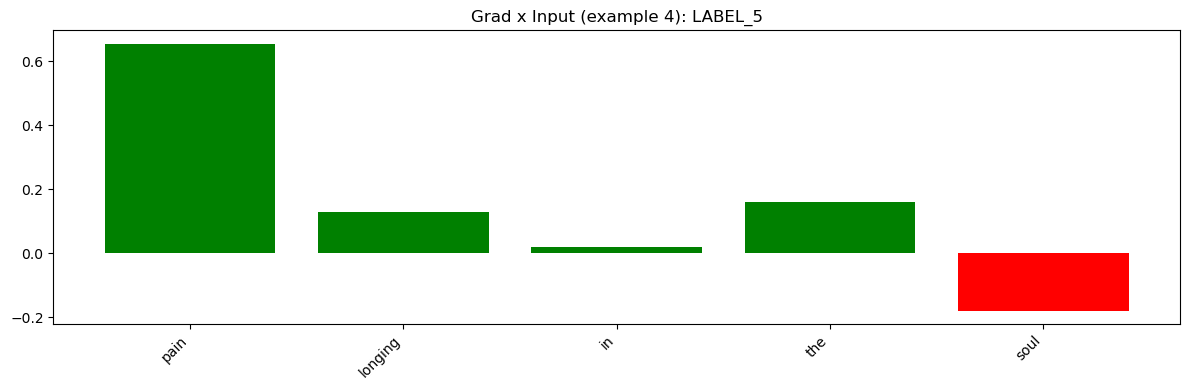

/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()



=== Example 5 ===
Emotion: sadness
RU text: Без общения больше месяца
EN text: without communication for more than a month
Predicted emotion: LABEL_5


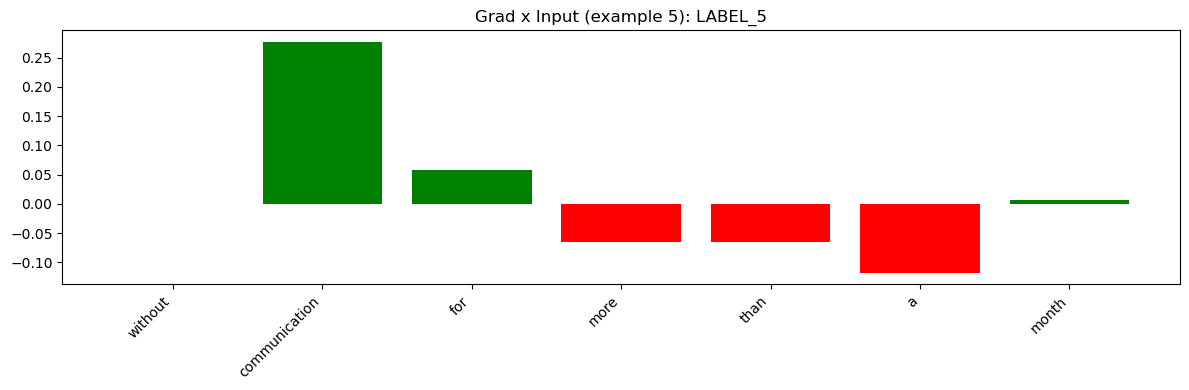

/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()



=== Example 6 ===
Emotion: sadness
RU text: Мазурка сербского оказалась плоским пирогом, весьма сухим.
EN text: serbian mazurka turned out to be a flat pie very dry
Predicted emotion: LABEL_4


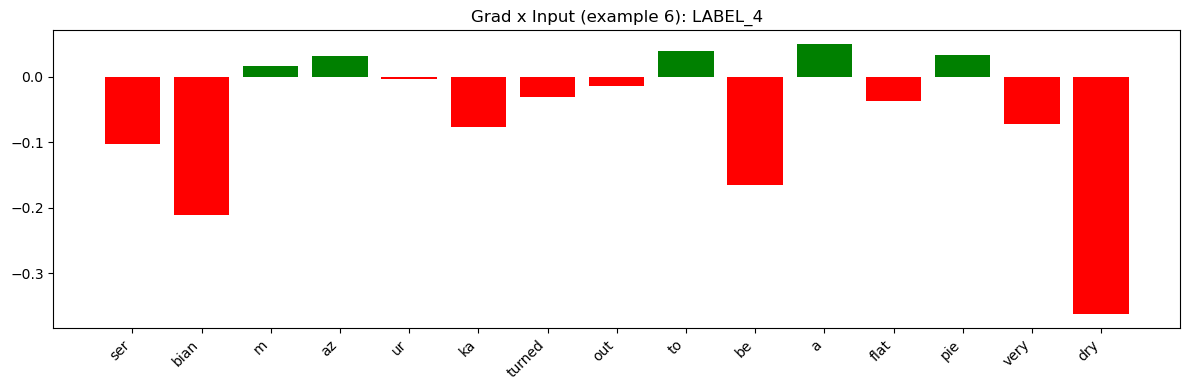

/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()



=== Example 7 ===
Emotion: anger
RU text: У меня большие претензии к блюдам.
EN text: i have big complaints about dishes
Predicted emotion: LABEL_0


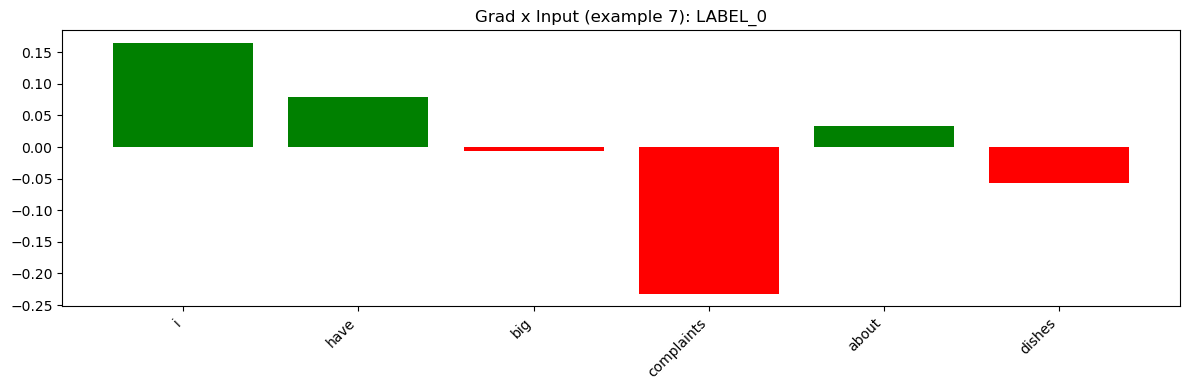

/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()



=== Example 8 ===
Emotion: anger
RU text: И я думаю, он подверг критике то, что было блюдо со свининой.
EN text: and i think he criticized what was a dish with pork
Predicted emotion: LABEL_0


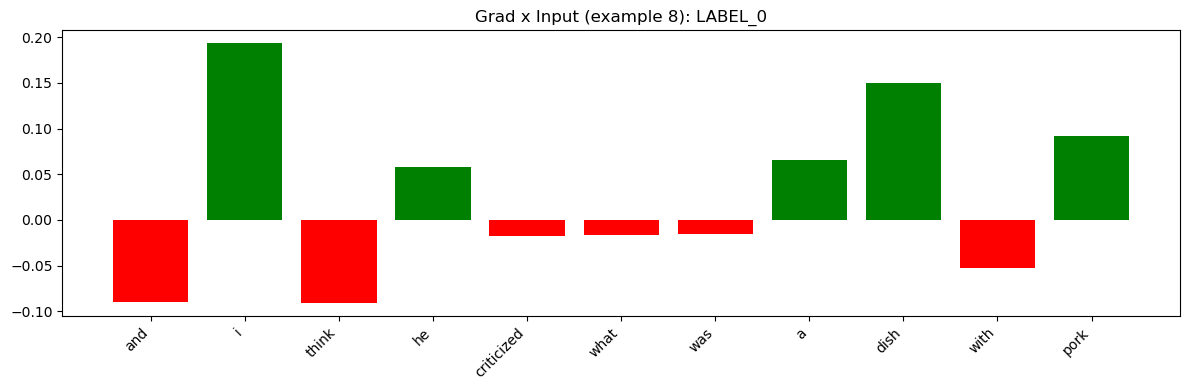

/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()



=== Example 9 ===
Emotion: anger
RU text: Но я, если честно, руками есть не люблю.
EN text: but to be honest i don t like my hands
Predicted emotion: LABEL_0


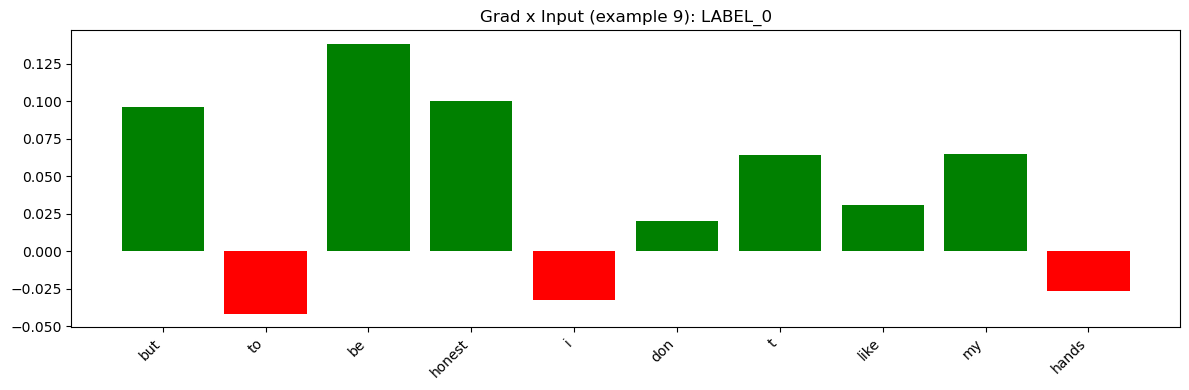


=== Example 10 ===
Emotion: surprise
RU text: Я его половую принадлежность даже не могу понять.
EN text: i can not even understand his gender
Predicted emotion: LABEL_6


/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()


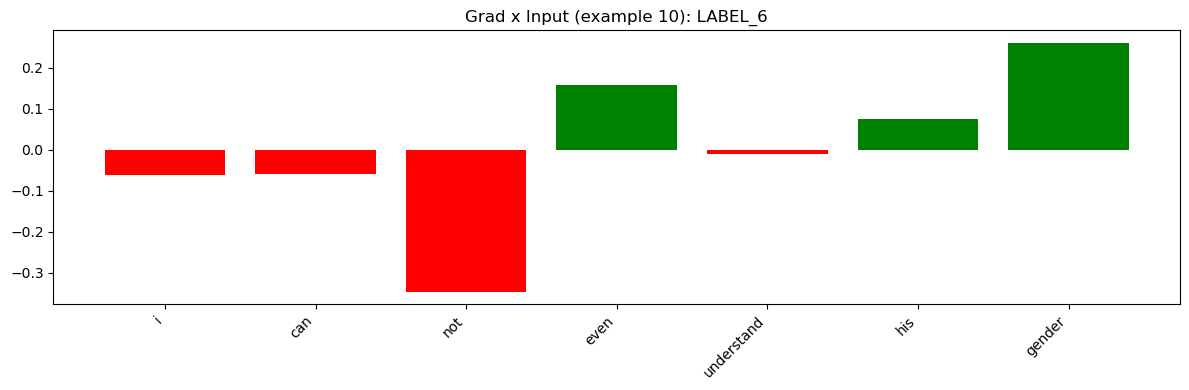

/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()



=== Example 11 ===
Emotion: surprise
RU text: что между ними возникла взаимная симпатия.
EN text: that mutual sympathy arose between them
Predicted emotion: LABEL_3


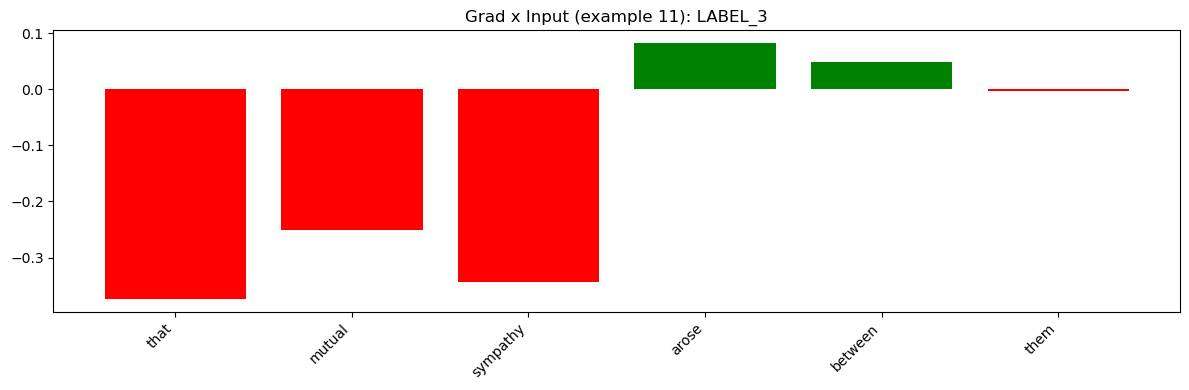

/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()



=== Example 12 ===
Emotion: surprise
RU text: Вы знаете, я немножечко о каждом уже кое-что знаю.
EN text: you know i already know something a little about everyone
Predicted emotion: LABEL_6


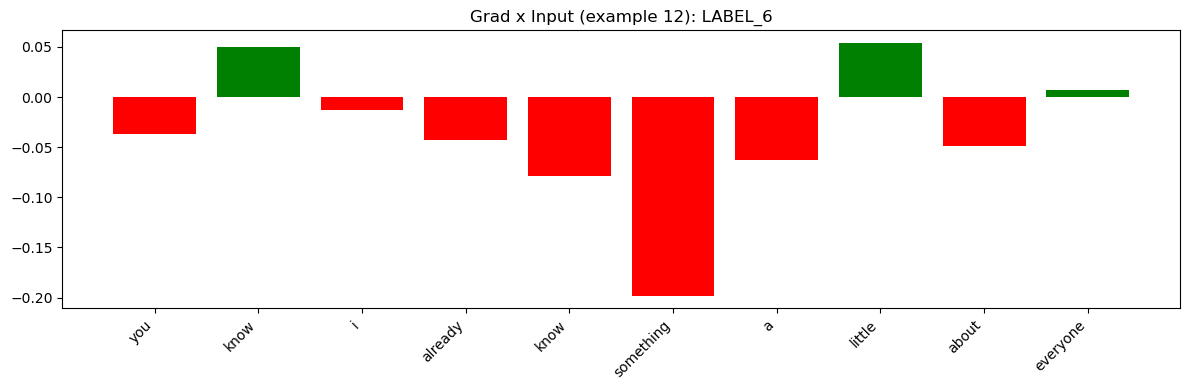

/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()



=== Example 13 ===
Emotion: fear
RU text: Скажу откровенно, я не знала ведь, кто ко мне придет,
EN text: frankly i did not know who would come to me
Predicted emotion: LABEL_6


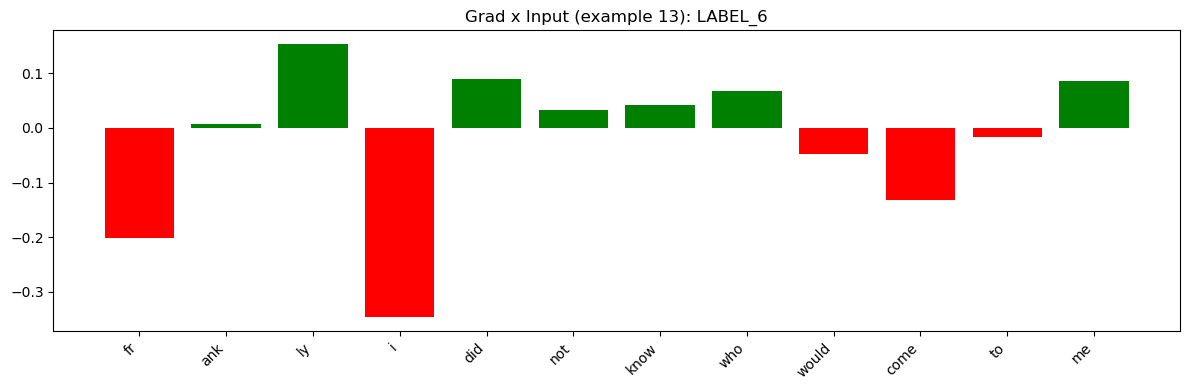

/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()



=== Example 14 ===
Emotion: fear
RU text: Я боюсь к нему идти.
EN text: i m afraid to go to him
Predicted emotion: LABEL_2


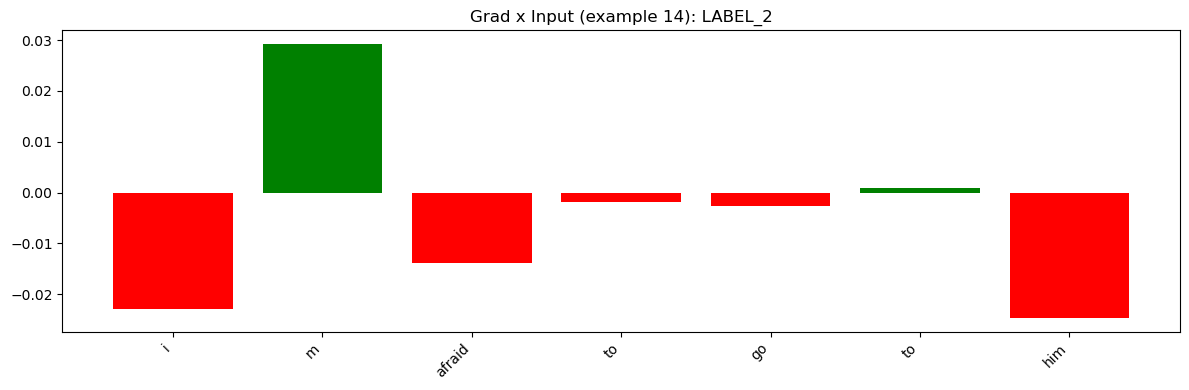

/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()



=== Example 15 ===
Emotion: fear
RU text: Очень вкусно, но я боюсь, что там
EN text: very tasty but i m afraid that there
Predicted emotion: LABEL_2


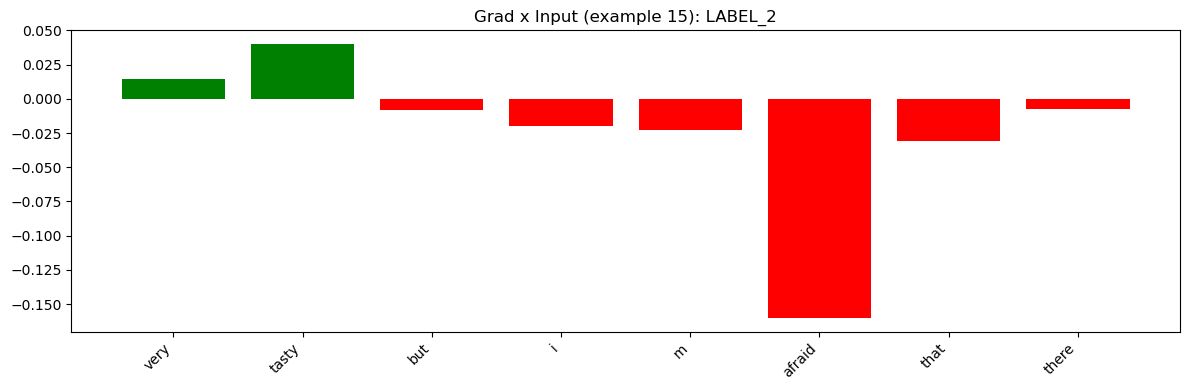

/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()



=== Example 16 ===
Emotion: disgust
RU text: Желудок-то забитый у вас у всех.
EN text: the stomach is clogged with you all
Predicted emotion: LABEL_4


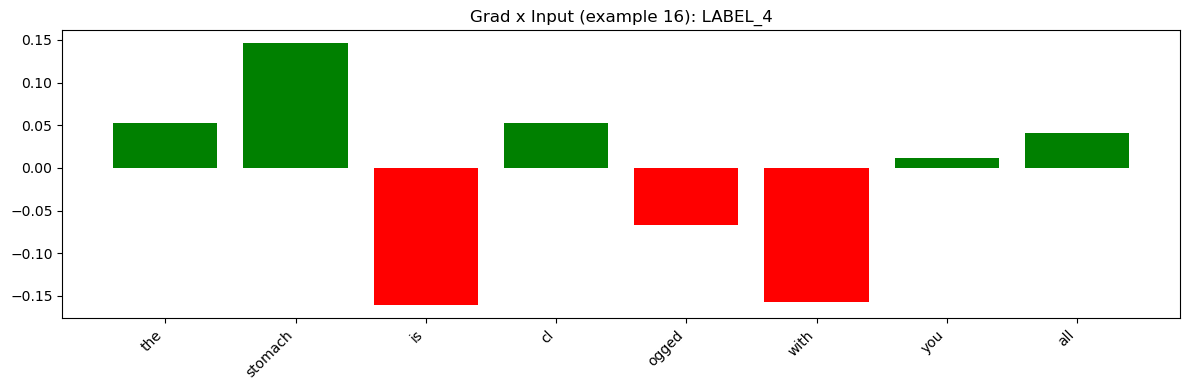

/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()



=== Example 17 ===
Emotion: disgust
RU text: острое неприятие
EN text: acute rejection
Predicted emotion: LABEL_0


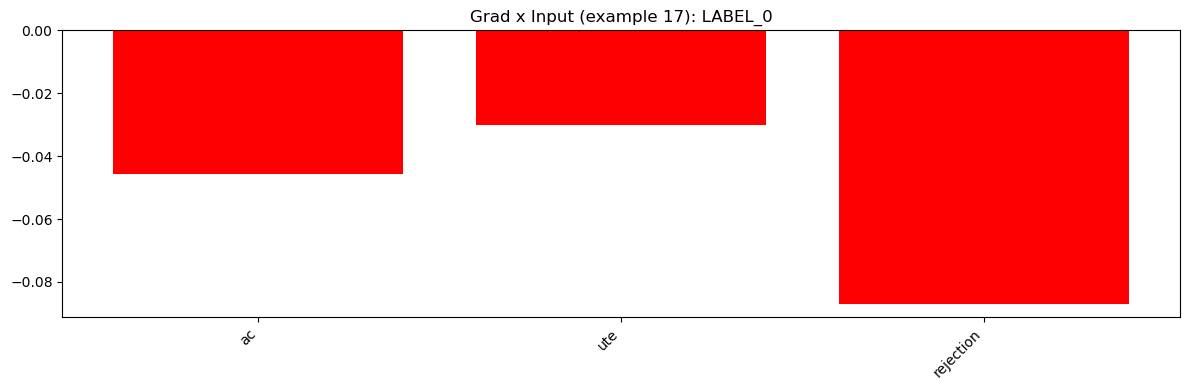


=== Example 18 ===
Emotion: disgust
RU text: того блюда, которое тебе подали.
EN text: the dishes that you were served
Predicted emotion: LABEL_4


/var/folders/6f/s2_hrtfn3rdf2fnl16v_t8mm0000gn/T/ipykernel_51049/1559745719.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()


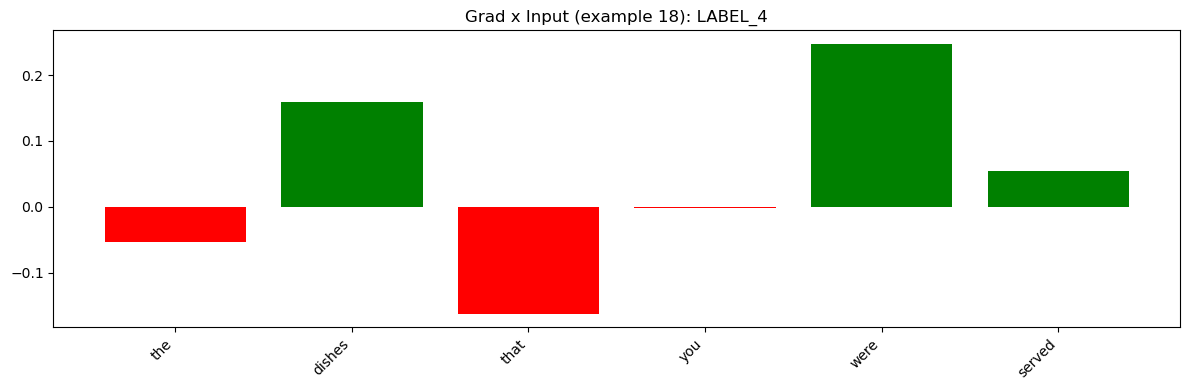


All done. You can analyze 'results' list for further usage or save it as JSON.


In [49]:
# ====== Inference + Gradient × Input for each sentence ======
# We'll store results in a list
results = []

# If your model has config.id2label, you can decode the predicted label
id2label = model.config.id2label if hasattr(model.config, 'id2label') else None

for i, example in enumerate(sample_sentences):
    en_text = example["text"]
    tokens, rel_scores, logits = grad_x_input_roberta(model, tokenizer, en_text, device=device, target_label=None)
    pred_label_id = torch.argmax(torch.tensor(logits), dim=1).item()

    if id2label:
        pred_label_str = id2label[pred_label_id]
    else:
        pred_label_str = str(pred_label_id)

    print(f"\n=== Example {i+1} ===")
    print(f"Emotion: {example['general_emotion']}")
    print(f"RU text: {example['ru_text']}")
    print(f"EN text: {en_text}")
    print(f"Predicted emotion: {pred_label_str}")

    # Visualize bar chart
    visualize_relevance(tokens, rel_scores, title=f"Grad x Input (example {i+1}): {pred_label_str}")

    # Optionally, store in results
    results.append({
        "index": i+1,
        "ru_text": example["ru_text"],
        "en_text": en_text,
        "pred_label": pred_label_str,
        "tokens": tokens,
        "relevance_scores": rel_scores.tolist()
    })

print("\nAll done. You can analyze 'results' list for further usage or save it as JSON.")

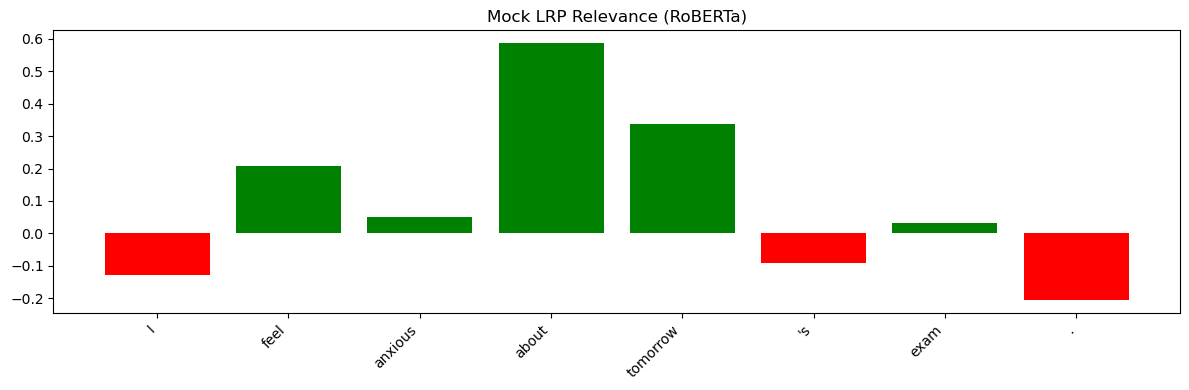

In [50]:
# ======== STEP 3: Simple (mock) LRP for RoBERTa ========
# Пояснения (по-русски):
# Реальная Conservative LRP требует патчей attention/layernorm.
# Здесь - упрощённый demo, показывающий, как вы бы распределили релевантность.
def roberta_lrp_mock(model, tokenizer, text):
    """
    Example: 1) forward pass
             2) create random relevance
             3) map tokens
    """
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        _ = model(**inputs)
    input_ids = inputs["input_ids"][0].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)

    # mock relevance
    # real LRP code would do layer-by-layer backprop
    seq_len = len(tokens)
    relevance = np.random.randn(seq_len) * 0.2

    return tokens, relevance

def demo_lrp_mock():
    text = "I feel anxious about tomorrow's exam."
    toks, rel = roberta_lrp_mock(model, tokenizer, text)
    visualize_relevance(toks, rel, "Mock LRP Relevance (RoBERTa)")

demo_lrp_mock()

In [51]:
# ======== STEP 4: Input Perturbation ========
def input_perturbation(model, tokenizer, text, relevance_scores, remove_least=True):
    """
    We remove tokens one by one, from least relevant or most relevant.
    Then measure model confidence for the original predicted class.
    """
    # 1) get predicted label
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model(**inputs)
        logits = out.logits
        pred_label = torch.argmax(logits, dim=1).item()
        probs = F.softmax(logits, dim=1)
        initial_conf = probs[0, pred_label].item()

    # 2) sort tokens by ascending or descending
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].cpu().numpy(), skip_special_tokens=False)
    # skip special tokens in logic if you want
    indexed_scores = list(enumerate(relevance_scores))

    if remove_least:
        # ascending
        sorted_idx = sorted(indexed_scores, key=lambda x: x[1])  # by score
    else:
        # descending
        sorted_idx = sorted(indexed_scores, key=lambda x: x[1], reverse=True)

    confs = [initial_conf]
    # We'll create a copy of input_ids
    mod_input_ids = inputs["input_ids"][0].clone()
    for i in range(len(tokens)):
        # remove i-th token in sorted order (set to <pad>)
        idx_to_remove, _ = sorted_idx[i]
        if idx_to_remove < len(mod_input_ids):
            mod_input_ids[idx_to_remove] = tokenizer.convert_tokens_to_ids("<pad>")  # pad token

        new_inp = {
            "input_ids": mod_input_ids.unsqueeze(0),
            "attention_mask": inputs["attention_mask"]
        }
        with torch.no_grad():
            new_out = model(**new_inp)
            new_probs = F.softmax(new_out.logits, dim=1)
            conf = new_probs[0, pred_label].item()
            confs.append(conf)

    return tokens, confs

def visualize_perturbation(tokens, confs, title="Token Removal Perturbation"):
    x = np.arange(len(confs))
    plt.figure(figsize=(10,4))
    plt.plot(x, confs, marker='o')
    plt.axhline(y=0.5, color='red', linestyle='--', label="0.5 Confidence Threshold")
    plt.title(title)
    plt.xlabel("Number of tokens removed")
    plt.ylabel("Confidence in original predicted label")
    plt.legend()
    plt.show()

In [52]:
# DEMO
text_demo2 = "I am furious about how badly this event was organized."
# 1) get GxI
toks_gxi2, rel_gxi2 = grad_x_input_roberta(model, tokenizer, text_demo2, device=device)
# 2) perturb removing least relevant tokens first
toks, confs = input_perturbation(model, tokenizer, text_demo2, rel_gxi2, remove_least=True)
visualize_perturbation(toks, confs, title="Removing least relevant (Grad x Input)")

# END
print("Done: XAI (Grad x Input, mock LRP, token perturbation) for RoBERTa.")

ValueError: too many values to unpack (expected 2)